In [2]:
import numpy as np
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense,Dropout, Conv2D, Flatten,Conv2DTranspose,LeakyReLU,Reshape
from PIL import ImageFile
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from cv2 import cv2
ImageFile.LOAD_TRUNCATED_IMAGES = True
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

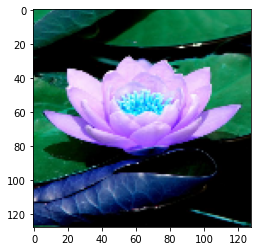

In [7]:
#load data
import pickle 
pickle_in = open('Flwrs.pickle','rb')
Flowers = np.array(pickle.load(pickle_in))
plt.imshow(Flowers[433])
plt.show()

In [8]:
#examine data
print(Flowers.shape)


(8189, 128, 128, 3)


In [16]:
def create_discreminator(in_shape=(128,128,3)):
    model = Sequential([
        Conv2D(128, (3,3),strides=(2,2), padding='same', input_shape=in_shape), #64x64
        LeakyReLU(alpha=0.2),
        Conv2D(128, (3,3),strides=(2,2), padding='same'), #32x32
        LeakyReLU(alpha=0.2),
        Conv2D(128, (3,3),strides=(2,2), padding='same'), #16x16
        LeakyReLU(alpha=0.2),
        Conv2D(128, (3,3),strides=(2,2), padding='same'), #8x8
        LeakyReLU(alpha=0.2),
        Flatten(),
        Dropout(0.3),
        Dense(1,activation='sigmoid'),
         ])
    opt = Adam(lr=0.0002,beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

def create_generator(latent):
    n_nodes= 128*8*8
    model = Sequential([
        Dense(n_nodes,input_dim=latent),
        LeakyReLU(alpha=0.2),
        Reshape((8,8,128)),
        Conv2DTranspose(128,(4,4), strides=(2,2), padding='same'), #16*16
        LeakyReLU(alpha=0.2),
        Conv2DTranspose(128,(4,4), strides=(2,2), padding='same'), #32*32
        LeakyReLU(alpha=0.2),
        Conv2DTranspose(128,(4,4), strides=(2,2), padding='same'), #64*64
        LeakyReLU(alpha=0.2),
        Conv2DTranspose(128,(4,4), strides=(2,2), padding='same'), #128*128
        LeakyReLU(alpha=0.2),
        Conv2D(3,(8,8),activation='tanh',padding='same'), #128*128*3
        ])
    return model



def create_gan(generator,discreminator):
    discreminator.trainable=False
    model = Sequential ([
        generator,
        discreminator,
    ])
    opt=Adam(lr=0.0002,beta_1=0.5)
    model.compile(loss='binary_crossentropy',optimizer=opt)
    discreminator.trainable=True
    return model


def load_real_samples(trainX):
    X=np.array(trainX)
    X=X.astype('float32')
    #scale from (0,255) to (-1,1)
    X = (X-127.5)/127.5
    return X


def generate_real_samples(dataset,n_samples):
    #pick random images
    ix=np.random.randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y=np.ones((n_samples,1))
    return X,y


def generate_latent(latent_dim,n_samples):
    x_input= np.random.randn(latent_dim*n_samples)
    x_input = x_input.reshape(n_samples,latent_dim)
    return x_input


def generate_fake_samples(generator,latent_dim,n_samples):
    x_input=generate_latent(latent_dim,n_samples)
    X = generator.predict(x_input,verbose=0)
    y=np.zeros((n_samples,1))
    return X,y


def train(g_model,d_model,gan_model,dataset,latent_dim,n_epochs,n_batch=64):
    batch_per_epoch=int(dataset.shape[0]/n_batch)
    half_batch = int(n_batch/2)

    for i in range(n_epochs):
        for j in range(batch_per_epoch):
            X_real,y_real = generate_real_samples(dataset,half_batch)
            d_loss_real,_= d_model.train_on_batch(X_real,y_real)

            X_fake,y_fake= generate_fake_samples(g_model,latent_dim,half_batch)
            d_loss_fake,_ = d_model.train_on_batch(X_fake,y_fake)


            X_gan = generate_latent(latent_dim,n_batch)
            y_gan = np.ones((n_batch,1))

            g_loss = gan_model.train_on_batch(X_gan,y_gan)
        #Save the model every 2 epochs
        if i%2 ==0:
            g_model.save('Generator.h5')
            d_model.trainable=True
            d_model.save('Discriminator.h5',include_optimizer=True)
            gan_model.save('GAN.h5',include_optimizer=True)


    



In [ ]:
from keras.models import load_model
latent_dim = 100

Discriminator = create_discreminator()
Generator = create_generator(latent_dim)
GAN = create_gan(Generator,Discriminator)

dataset=load_real_samples(Flowers)

train(Generator,Discriminator,GAN,dataset,latent_dim,n_epochs=10)

1/1 [==============================] - 0s 429ms/step


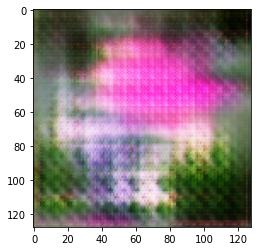

In [19]:
#Lets generate a picture of a flower after 10 epochs of training: 
latent = generate_latent(100,1)
X = Generator.predict(latent)
X = (X +1)/2
X = (X*255).astype(np.uint8)
plt.imshow(cv2.cvtColor(X[0], cv2.COLOR_BGR2RGB))

1/1 [==============================] - 0s 149ms/step


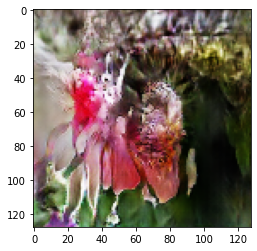

In [21]:
#Here are some experiments with my previously trained Generators

#Generator trained for 200 Epochs
Generator = load_model('CheckPoint_200Epoch/Generator.h5')
latent = generate_latent(100,1)
X = Generator.predict(latent)
X = (X +1)/2
X = (X*255).astype(np.uint8)
plt.imshow(cv2.cvtColor(X[0], cv2.COLOR_BGR2RGB))

1/1 [==============================] - 0s 146ms/step


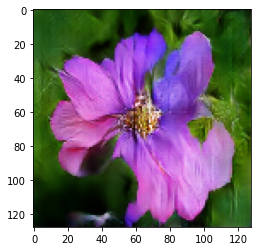

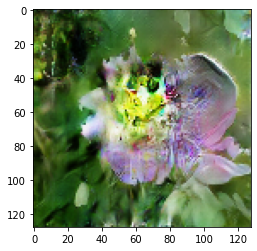

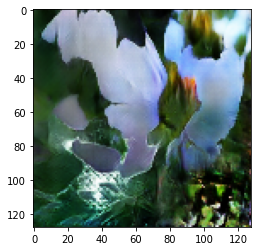

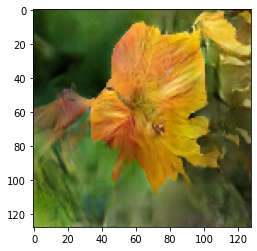

In [57]:
#Generator trained for 500 Epochs
Generator = load_model('CheckPoint_500Epoch/Generator.h5')
latent = generate_latent(100,4)
X = Generator.predict(latent)
X = (X +1)/2
X = (X*255).astype(np.uint8)
for i in range(0,latent.shape[0]):
    plt.imshow(cv2.cvtColor(X[i], cv2.COLOR_BGR2RGB))
    plt.show()
